# Week 07 Homework - Kendall Gilbert

In [60]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd
import rioxarray as rxr
import xarray as xr

### 7.1 Calculating the Normalized Difference Index
From [https://www.usgs.gov/landsat-missions/landsat-normalized-difference-vegetation-index](https://www.usgs.gov/landsat-missions/landsat-normalized-difference-vegetation-index)... the Normalized Difference Vegetation Index (NDVI) is used to quantify vegetation greenness and is useful in understanding vegetation density and assessing changes in plant health. NDVI is calculated as a ratio between the red (R) and near infrared (NIR) values in traditional fashion: 

(NIR - R) / (NIR + R)

NDVI always ranges from -1 to +1. But there isn’t a distinct boundary for each type of land cover. For example, when you have negative values, it’s highly likely that it’s water. On the other hand, if you have an NDVI value close to +1, there’s a high possibility that it’s dense green leaves. But when NDVI is close to zero, there are likely no green leaves and it could even be an urbanized area.

For this first exercise you will calculate NDVI over the LMU campus.

1. Load both red (``` 'data/2023-02-22-sentinel-2-red-band.tiff' ```) and NIR (``` 'data/2023-02-22-sentinel-2-NIR-band.tiff' ```) bands from images taken from Sentinel-2 satellite over the LMU campus on February 22, 2023. Make sure when loading to use ```masked=True ```. Why do we want to do this? Check to see if the bounds, resolution and CRS are the same for both datasets. 

In [61]:
#Load data with masked = True
redBands = rxr.open_rasterio('data/2023-02-22-sentinel-2-red-band.tiff', masked=True)
NIRBands = rxr.open_rasterio('data/2023-02-22-sentinel-2-NIR-band.tiff', masked=True)

#Check to see if the bounds are the same
if redBands.rio.bounds() == NIRBands.rio.bounds():
    print('The bounds are the same for both datasets.')
else:
    print('The bounds are not the same for both datasets.')

#Check to see if the resolutions are the same
if redBands.rio.resolution() == NIRBands.rio.resolution():
    print('The resolutions are the same for both datasets.')
else:
    print('The resolutions are not the same for both datasets.')

#Check to see if the crs are the same
if redBands.rio.crs == NIRBands.rio.crs:
    print('The crs are the same for both datasets.')
else:
    print('The crs are not the same for both datasets.')

The bounds are the same for both datasets.
The resolutions are the same for both datasets.
The crs are the same for both datasets.


We want to load the data with masked=True, so that any no data values are masked.

2. Calculate the NDVI. Export and save to a file as ``` 'data/2023-02-22-sentinel-2-NDVI.tiff' ```

In [62]:
#Calculate NDVI
NDVI = (NIRBands - redBands)/(NIRBands + redBands)

#Export and save to a file with the dersired path
NDVI.rio.to_raster('data/2023-02-22-sentinel-2-NDVI.tiff')

3. Plot the NDVI data using the colormap ```RdYlGn```. Write 1-2 sentences describing patterns you notice.

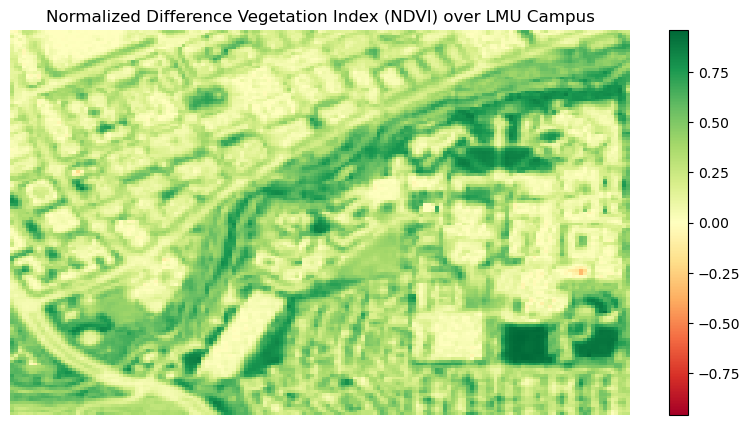

In [63]:
#Plot the NDVI data
f, ax = plt.subplots(figsize=(10, 5))
#Select the desired colormap
NDVI.plot(cmap="RdYlGn")
ax.set(title="Normalized Difference Vegetation Index (NDVI) over LMU Campus")
ax.set_axis_off()
plt.show()

The map has identified large green areas correctly as being dark green and having an NDVI close to 1. Grassy areas of LMU's campus are in this category as well as the Bluff Creek Trail area. It also identified the buildings correctly with a NDVI close to 0, which typically represents urban areas, and the LMU pool is identified with a negative NDVI. 

4. Create a histogram with the custom bins: ```  bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1] ```. Write 1-2 sentences explaining patterns you notice. Lastly, print the max and min values. 

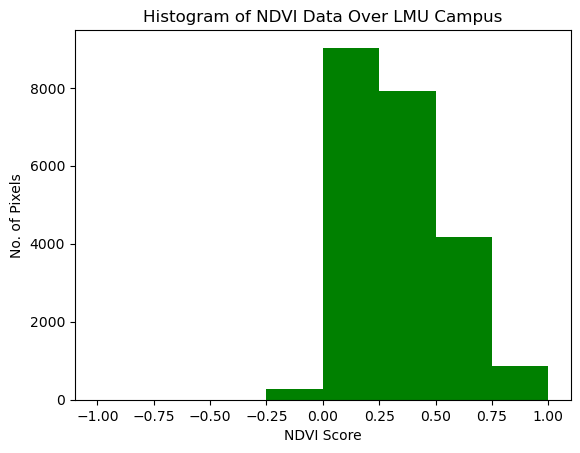

In [64]:
#Create a histogram 
f, ax = plt.subplots()
#Select custom bins for the histogram
NDVI.plot.hist(color="green",
                        bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
ax.set(title="Histogram of NDVI Data Over LMU Campus",
       xlabel="NDVI Score",
       ylabel="No. of Pixels")
plt.show()

The vast majority of the data is slightly greater than 0, indicating likely urban areas with very little vegetation. There is some data closer to 1, indicating the highly vegetated areas of the LMU campus area, like the lawns on campus. There is very little data less than 0 because there is not much water on the map, aside from the LMU pool.

In [65]:
#Print the max and min NDVI values
print('NDVI minimum value: ', np.nanmin(NDVI))
print('NDVI maximum value: ', np.nanmax(NDVI))

NDVI minimum value:  -0.3420191
NDVI maximum value:  0.95758915


### 7.2  Manually Reclassify NDVI Data
Buildling on 7.1, let's now reclassify the NDVI data to more meaningful symbologies. 

1. Use the following breaks to reclassify the NDVI data:
- <0: water 
- 0 to 0.2: urban/barren
- 0.2 to 0.5: low vegetation
- $\gt$ 0.5: high vegetation

Note that you **do not** have to do any additional masking as your NoData mask already occured when loading in the data. 

In [66]:
breaks = [-1, 0, 0.2, 0.5, 1]

NDVIReclass = xr.apply_ufunc(np.digitize,
                                     NDVI,
                                     breaks)

2. Plot the data using the following parameters:
- ```colors = ['blue', 'beige', 'green', 'darkgreen']```
- ```class_bins = [0.5, 1.5, 2.5, 3.5, 4.5]```

Write a few sentences of what you observe. Where does this classification scheme do well? Where does it not do well? Think of what you see walking around campus and how it compares to the map you generated. 

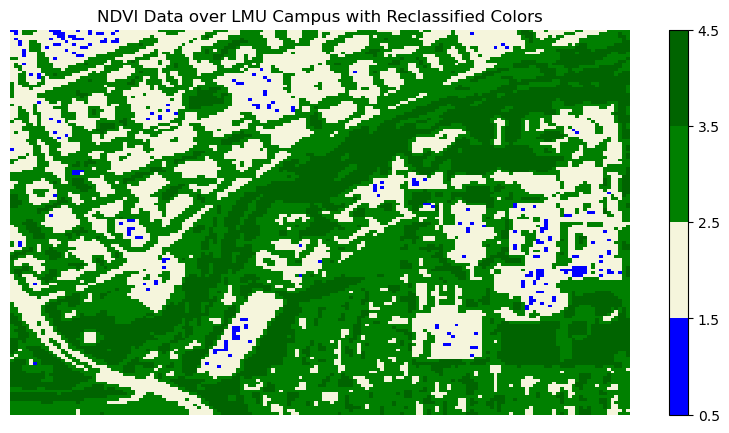

In [67]:
#Set the color and class bin parameters
colors = ['blue', 'beige', 'green', 'darkgreen']
class_bins = [0.5, 1.5, 2.5, 3.5, 4.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, 
                    len(colors))

# Plot the data 
f, ax = plt.subplots(figsize=(10, 5))
NDVIReclass.plot(cmap=cmap,norm=norm)
ax.set(title="NDVI Data over LMU Campus with Reclassified Colors")
ax.set_axis_off()
plt.show()

This classification scheme does well at classifying the vegetated areas as dark green, and classifying buildings and large roads under the beige urban color. It seems to overestimate the amount of areas that are water including some pixels that are on the roofs of buildings. It also misses several smaller roads and classifies them as low vegetation instead. 

3. Create a histogram of the classified NDVI data. Give rough approximations of the percentages of each cateogry (i.e. ~20% water, ~40% barren/urban land etc.)

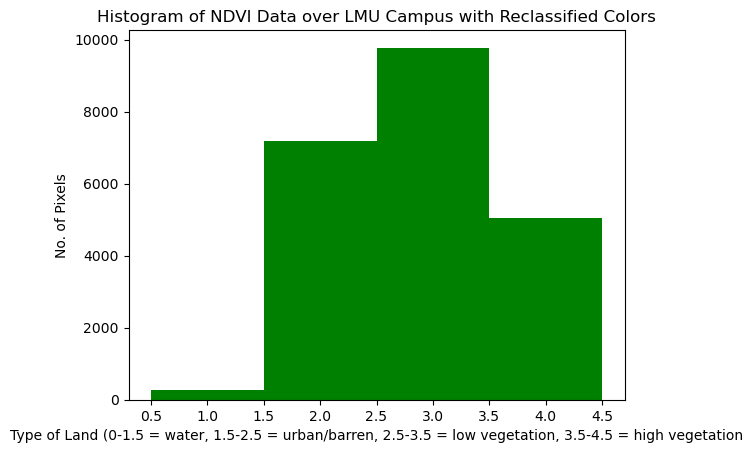

In [68]:
#Create a histogram 
f, ax = plt.subplots()
NDVIReclass.plot.hist(
    color='green',
    bins=[0.5, 1.5, 2.5, 3.5, 4.5])
ax.set(title="Histogram of NDVI Data over LMU Campus with Reclassified Colors",
       xlabel="Type of Land (0-1.5 = water, 1.5-2.5 = urban/barren, 2.5-3.5 = low vegetation, 3.5-4.5 = high vegetation",
       ylabel="No. of Pixels")
plt.show()

I would approximate that there is less than 5% water, around 35% urban/barren, around 40% low vegetation, and around 20% high vegetation.